# Second approach

In [353]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sympy as sp

In [354]:
plt.style.use(plt.style.available[9])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define Transfer Function

In [355]:
numerator = [-1, 1.9, 0.95]
denominator = [1, -0.18, 0.08, -0.08]
H_s = ctrl.tf(numerator,denominator)
H_s

TransferFunction(array([-1.  ,  1.9 ,  0.95]), array([ 1.  , -0.18,  0.08, -0.08]))

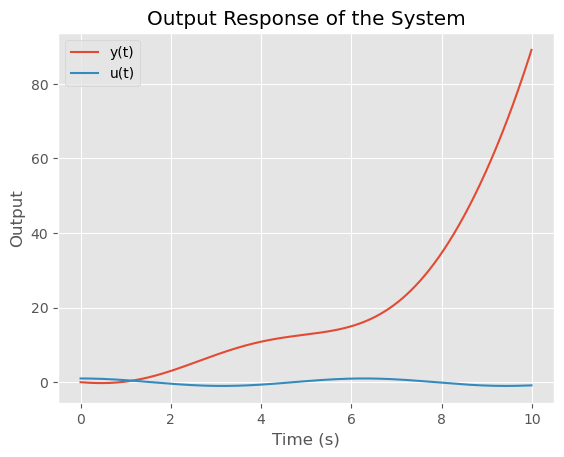

In [356]:
dt =0.01
time = np.arange(0, 10, dt)
f = 1
u_data = np.cos(f*time)#+np.cos(2*time)+np.cos(3*time)

# Step 3: Simulate the output using forced_response
results = ctrl.forced_response(H_s, T=time, U=u_data)

# Plotting the results
plt.figure()
plt.plot(results.time, results.outputs,label='y(t)')
plt.plot(time,u_data,label='u(t)')
plt.title('Output Response of the System')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.legend()

plt.show()

## Neural Network

In [357]:
class DeepNetwork(torch.nn.Module):
    def __init__(self, input_dim=8, hidden_dims=[128, 128, 128], num_classes=5):
        super(DeepNetwork, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Build the hidden layers
        for i in range(len(dims) - 1):
            layers.append(torch.nn.Linear(dims[i], dims[i + 1]))
            layers.append(torch.nn.ReLU())
        
        # Output layer
        layers.append(torch.nn.Linear(dims[-1], num_classes))
        
        # Sequentially stack the layers
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

## Generating White Noise Data

In [358]:
def generate_delayed_data(data, delays):
    delayed_data = []
    for delay in delays:
        padded_data = torch.cat([torch.zeros(delay), data[:-delay]])
        delayed_data.append(padded_data)
    return torch.stack(delayed_data, dim=1)

In [359]:
# Example white noise input signal
torch.manual_seed(42)
input_signal = torch.randn(50)
time = np.arange(0, 10, 0.2)
input_delays = [1, 2]
output_delays = [1, 2]

# Generate delayed input data
input_data_d = generate_delayed_data(input_signal, input_delays)
input_data = torch.cat([input_signal.reshape(-1, 1), input_data_d], dim=1).to(device)

# Generate system response using control library
T, y_ = ctrl.forced_response(H_s, T=time, U=input_signal.numpy())

# Convert output response to PyTorch tensor and generate delayed outputs
output_signal = torch.from_numpy(y_)  # Convert to PyTorch tensor
output_data = generate_delayed_data(output_signal, output_delays).to(device)

In [360]:
model = DeepNetwork(input_dim=input_data.shape[1] + output_data.shape[1], hidden_dims=[64], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare the data
X = torch.cat([input_data, output_data], dim=1).to(device).float()
y = torch.from_numpy(y_).to(device).float().reshape(-1,1)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if epoch %5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 62.48456573486328
Epoch 5000, Loss: 0.00017226494674105197


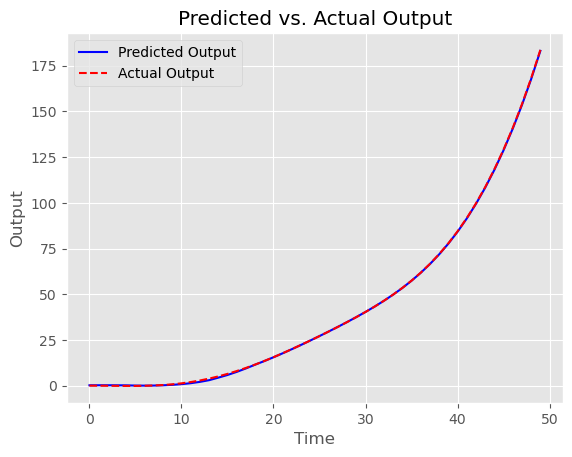

In [361]:
# Test the model with a new input signal (e.g., a sine wave)
test_input = torch.sin(torch.linspace(0, 10, 50))
test_input_data = generate_delayed_data(test_input, input_delays)
test_input_data = torch.cat([test_input.reshape(-1, 1), test_input_data], dim=1).to(device)

T, y_ = ctrl.forced_response(H_s, T=time, U=test_input.numpy())
test_output_data = generate_delayed_data(torch.from_numpy(y_), output_delays).to(device)
X_test = torch.cat([test_input_data, test_output_data], dim=1).to(device).float()

# Combine delayed test input and output for prediction
X_test = torch.cat([test_input_data, test_output_data], dim=1).to(device).float()
predicted_output = model(X_test)

# Plot predicted output and actual output
plt.plot(predicted_output.detach().cpu().numpy(), label="Predicted Output", color="blue")
T, y_ = ctrl.forced_response(H_s, T=time, U=test_input.numpy())
plt.plot(y_, label="Actual Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

# Part II

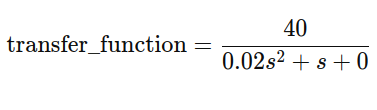
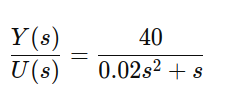
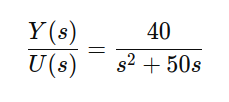

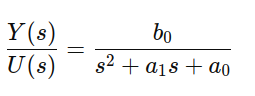
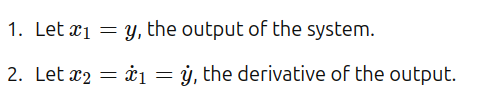
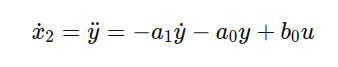


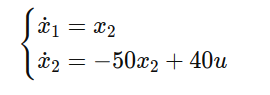
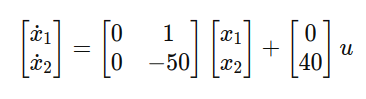

State parameters are the result of x1 and x2 when the sine wave is the input to the system. These states are obtained by solving the differential equation above.

## Neural Network

In [362]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepNetwork(torch.nn.Module):
    def __init__(self, input_dim=8, hidden_dims=[128, 128, 128], num_classes=5):
        super(DeepNetwork, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Build the hidden layers
        for i in range(len(dims) - 1):
            layers.append(torch.nn.Linear(dims[i], dims[i + 1]))
            layers.append(torch.nn.Sigmoid())
        
        # Output layer
        layers.append(torch.nn.Linear(dims[-1], num_classes))
        
        # Sequentially stack the layers
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

## Filter

In [363]:
def GetTheFilter_StateSpaceMats(A:sp.MutableDenseMatrix):
    s = sp.symbols('s')

    I = sp.eye(A.cols)
    
    M_s = (s*I-A).inv()
    sp.pprint(M_s)


    nums=[]
    dens=[]

    for entry in M_s:
        num_expr = sp.numer(entry)
        den_expr = sp.denom(entry)
        num_poly = sp.Poly(num_expr, s)
        den_poly = sp.Poly(den_expr, s)
        num_coeffs = [float(coef) for coef in num_poly.coeffs()]
        den_coeffs = [float(coef) for coef in den_poly.coeffs()]
        nums.append(num_coeffs)
        dens.append(den_coeffs)

    def GetNumDenReady(size,input):
        output = [[] for i in range(size)]

        for index, item in enumerate(input):
            group_index = index % size
            output[group_index].append(item)
        return output
    
    nums = GetNumDenReady(M_s.cols,nums)
    dens = GetNumDenReady(M_s.cols,dens)
    M_system = ctrl.tf(nums, dens)
    ss_sys = ctrl.tf2ss(M_system) 
    A = ss_sys.A
    B = ss_sys.B
    C = ss_sys.C
    D = ss_sys.D
    return M_system
A_filter = 1*sp.eye(1)
Filter = GetTheFilter_StateSpaceMats(A_filter)
Filter


⎡  1  ⎤
⎢─────⎥
⎣s - 1⎦


TransferFunction(array([1.]), array([ 1., -1.]))

## System

In [364]:
numerator = [1]
denominator = [1,0]
H_s = ctrl.tf(numerator,denominator)
H_s

TransferFunction(array([1]), array([1, 0]))

### input signal

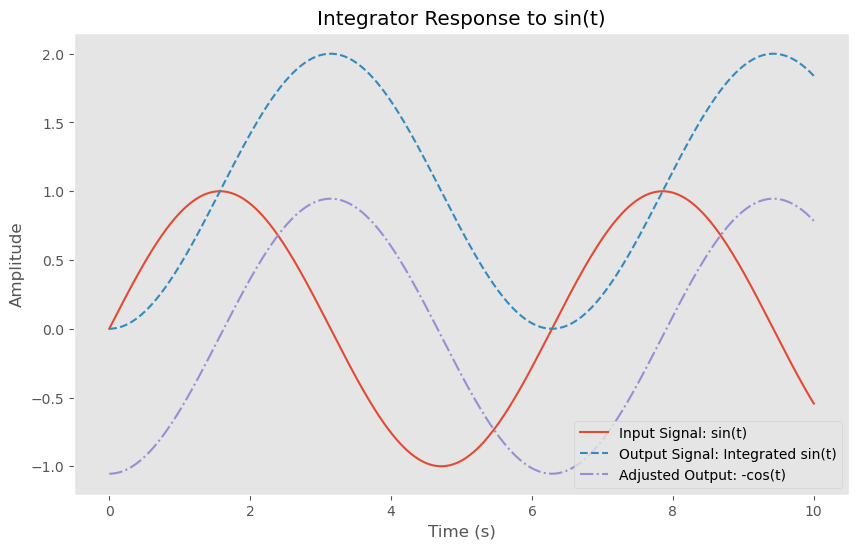

In [365]:
# Define time and input signal
num_pints = 1000
T_end = 10
t = np.linspace(0, T_end, num_pints)  # Time vector
input_signal = np.sin(t)  # Input signal

# Simulate the response
t_out, y_out_ = ctrl.forced_response(H_s, T=t, U=input_signal)

# Remove the DC offset (mean value)
y_out = y_out_ - np.mean(y_out_)

# Plot the input and output signals
plt.figure(figsize=(10, 6))
plt.plot(t, input_signal, label="Input Signal: sin(t)")
plt.plot(t_out, y_out_, label="Output Signal: Integrated sin(t)", linestyle='--')
plt.plot(t_out, y_out, label="Adjusted Output: -cos(t)", linestyle='-.')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Integrator Response to sin(t)")
plt.legend()
plt.grid()
plt.show()

### Train signal

In [366]:
torch.manual_seed(42)
input_signal_ = torch.randn(num_pints)
time = np.arange(0, T_end, T_end/num_pints)

T_, y_ = ctrl.forced_response(H_s, T=time, U=input_signal_)

output_signal = torch.from_numpy(y_).to(device)

x_hat = torch.rand_like(input_signal_)

# Prepare the data
X = torch.cat([input_signal_.reshape(-1, 1), input_signal_.reshape(-1, 1)], dim=1).to(device).float()
y = torch.from_numpy(y_).to(device).float().reshape(-1,1)


print(f'input_signal_ shape: {input_signal_.shape}')
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')


input_signal_ shape: torch.Size([1000])
X shape: torch.Size([1000, 2])
y shape: torch.Size([1000, 1])


In [367]:
model = DeepNetwork(input_dim=X.shape[1], hidden_dims=[64], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)    
    x_hat = outputs.detach() 
    T_, x_hat = ctrl.forced_response(Filter, T=time, U=x_hat.reshape(-1,).cpu().numpy())
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    
    X = torch.cat([input_signal_.reshape(-1, 1).to(device), torch.from_numpy(x_hat).reshape(-1,1).to(device)], dim=1).float()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.09116478264331818
Epoch 1000, Loss: 0.0015075966948643327
Epoch 2000, Loss: 0.0011996716493740678
Epoch 3000, Loss: 0.00111482257489115
Epoch 4000, Loss: 0.0011191440280526876
Epoch 5000, Loss: 0.001159471576102078
Epoch 6000, Loss: 0.0013908540131524205
Epoch 7000, Loss: 0.0010524821700528264
Epoch 8000, Loss: 0.0010307709453627467
Epoch 9000, Loss: 0.0011195673141628504


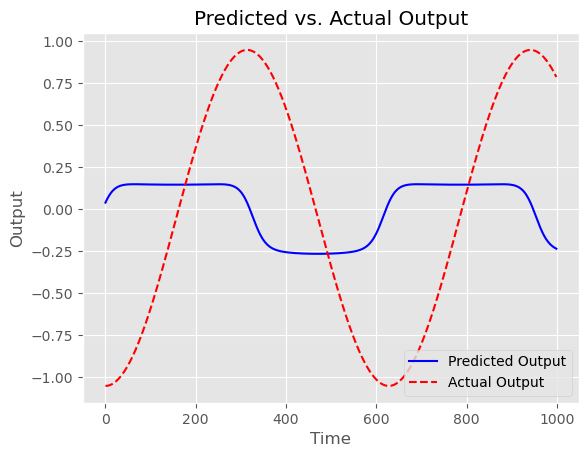

In [368]:
input_signal_torch = torch.from_numpy(input_signal).reshape(-1,1)
X_test = torch.cat([input_signal_torch, input_signal_torch], dim=1).to(device).float()

# Combine delayed test input and output for prediction
predicted_output = model(X_test)

# Plot predicted output and actual output
plt.plot(predicted_output.detach().cpu().numpy(), label="Predicted Output", color="blue")
plt.plot(y_out, label="Actual Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()